In [1]:
setwd('../../')
source('.Rprofile')
setwd('./benchmark/analysis')

library(ggplot2)
library(tidyverse)
library(ggpubr)
library(reshape2)
library(patchwork)

i Using R 4.3.1 (lockfile was generated with R 4.1.3)
[1] "/flash/grp/gglab/xiacr/SLAT-dev/renv/library/R-4.3/x86_64-pc-linux-gnu"         
[2] "/flash/grp/gglab/xiacr/SLAT-dev/renv/sandbox/R-4.3/x86_64-pc-linux-gnu/9a444a72"
python:         /flash/grp/gglab/xiacr/SLAT-dev/conda/bin/python
libpython:      /flash/grp/gglab/xiacr/SLAT-dev/conda/lib/libpython3.8.so
pythonhome:     /flash/grp/gglab/xiacr/SLAT-dev/conda:/flash/grp/gglab/xiacr/SLAT-dev/conda
version:        3.8.17 | packaged by conda-forge | (default, Jun 16 2023, 07:06:00)  [GCC 11.4.0]
numpy:          /flash/grp/gglab/xiacr/SLAT-dev/conda/lib/python3.8/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by use_python() function
[1] "/flash/grp/gglab/xiacr/SLAT-dev/conda/lib:/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/flash/grp/gglab/xiacr/SpatialLR-dev/resource/jdk1.8.0_361/lib/server:/opt/slurm-22.05.2/lib:/opt/slurm-22.05.2/lib/slurm:/opt/slurm-23.02.5/lib:/opt/slurm-23.02.5/lib/slurm:/opt/slurm-23.

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




In [2]:
data <- read_csv('../results/benchmark_aggr.csv')

# methods
data <- data[data$cells == 0,] %>% filter(!str_detect(method, 'one2many') | str_detect(method, 'PASTE')) %>%
        mutate(method = replace(method, method == 'SLAT_dpca', 'SLAT'))
data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))
data[nrow(data) + 1,] <- list("stereo_mouse_embryo",0,0,'PASTE',NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA) # PASTE can not run on Stereo-seq

# dataset
data <- data %>% filter(!str_detect(dataset, 'seqfish')) %>%
  mutate(group = ifelse(grepl('visium', dataset), 'Visium', ifelse(grepl('merfish', dataset), 'MERFISH', 'Stereo-seq'))) %>%
  mutate(group = factor(group, levels = c('Visium','MERFISH','Stereo-seq'))) %>%
  mutate(method = factor(method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))) 
data %>% head()

Rows: 205 Columns: 18
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): dataset, method
dbl (16): cells, seed, angle_delta, celltype_macro_f1, celltype_micro_f1, ce...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,cells,seed,method,angle_delta,celltype_macro_f1,celltype_micro_f1,celltype_score,edge_score,euclidean_dis,global_score,match_ratio,region_macro_f1,region_micro_f1,region_score,run_time,total_macro_f1,total_micro_f1,group
<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
merfish_mouse_hypothalamic_b0b1,0,0,Harmony,1.0269477,0.56300793,0.7416118,0.7416118,-43.92255,0.39506681,0.23737849,-1,0.2630906,0.3135779,0.3135779,8.309571,0.08231662,0.23737849,MERFISH
merfish_mouse_hypothalamic_b0b1,0,0,PASTE,3.6220226,0.05787487,0.1522421,0.1522421,-809.18783,0.34642832,0.03998119,-1,0.1658496,0.1718407,0.1718407,27.130379,0.01412990,0.03998119,MERFISH
merfish_mouse_hypothalamic_b0b1,0,0,SLAT,0.4245085,0.56144961,0.7477266,0.7477266,-41.33082,0.05467456,0.54060834,-1,0.6757524,0.7235811,0.7235811,4.662091,0.32835072,0.54060834,MERFISH
merfish_mouse_hypothalamic_b0b1,0,0,STAGATE,2.9652431,0.10506340,0.2434933,0.2434933,-55.67012,0.42400166,0.07071182,-1,0.2035809,0.2395735,0.2395735,30.458607,0.02090321,0.07071182,MERFISH
merfish_mouse_hypothalamic_b0b1,0,0,Seurat,1.3669326,0.55015158,0.7420822,0.7420822,-44.49890,0.39618951,0.23910317,-1,0.2609215,0.3112261,0.3112261,81.068000,0.08364329,0.23910317,MERFISH
merfish_mouse_hypothalamic_b10b11,0,0,Harmony,1.9172612,0.52489040,0.7347936,0.7347936,-44.28856,0.43709817,0.16002896,-1,0.1706475,0.2146995,0.2146995,7.639196,0.06879946,0.16002896,MERFISH


`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_errorbarh()`).”


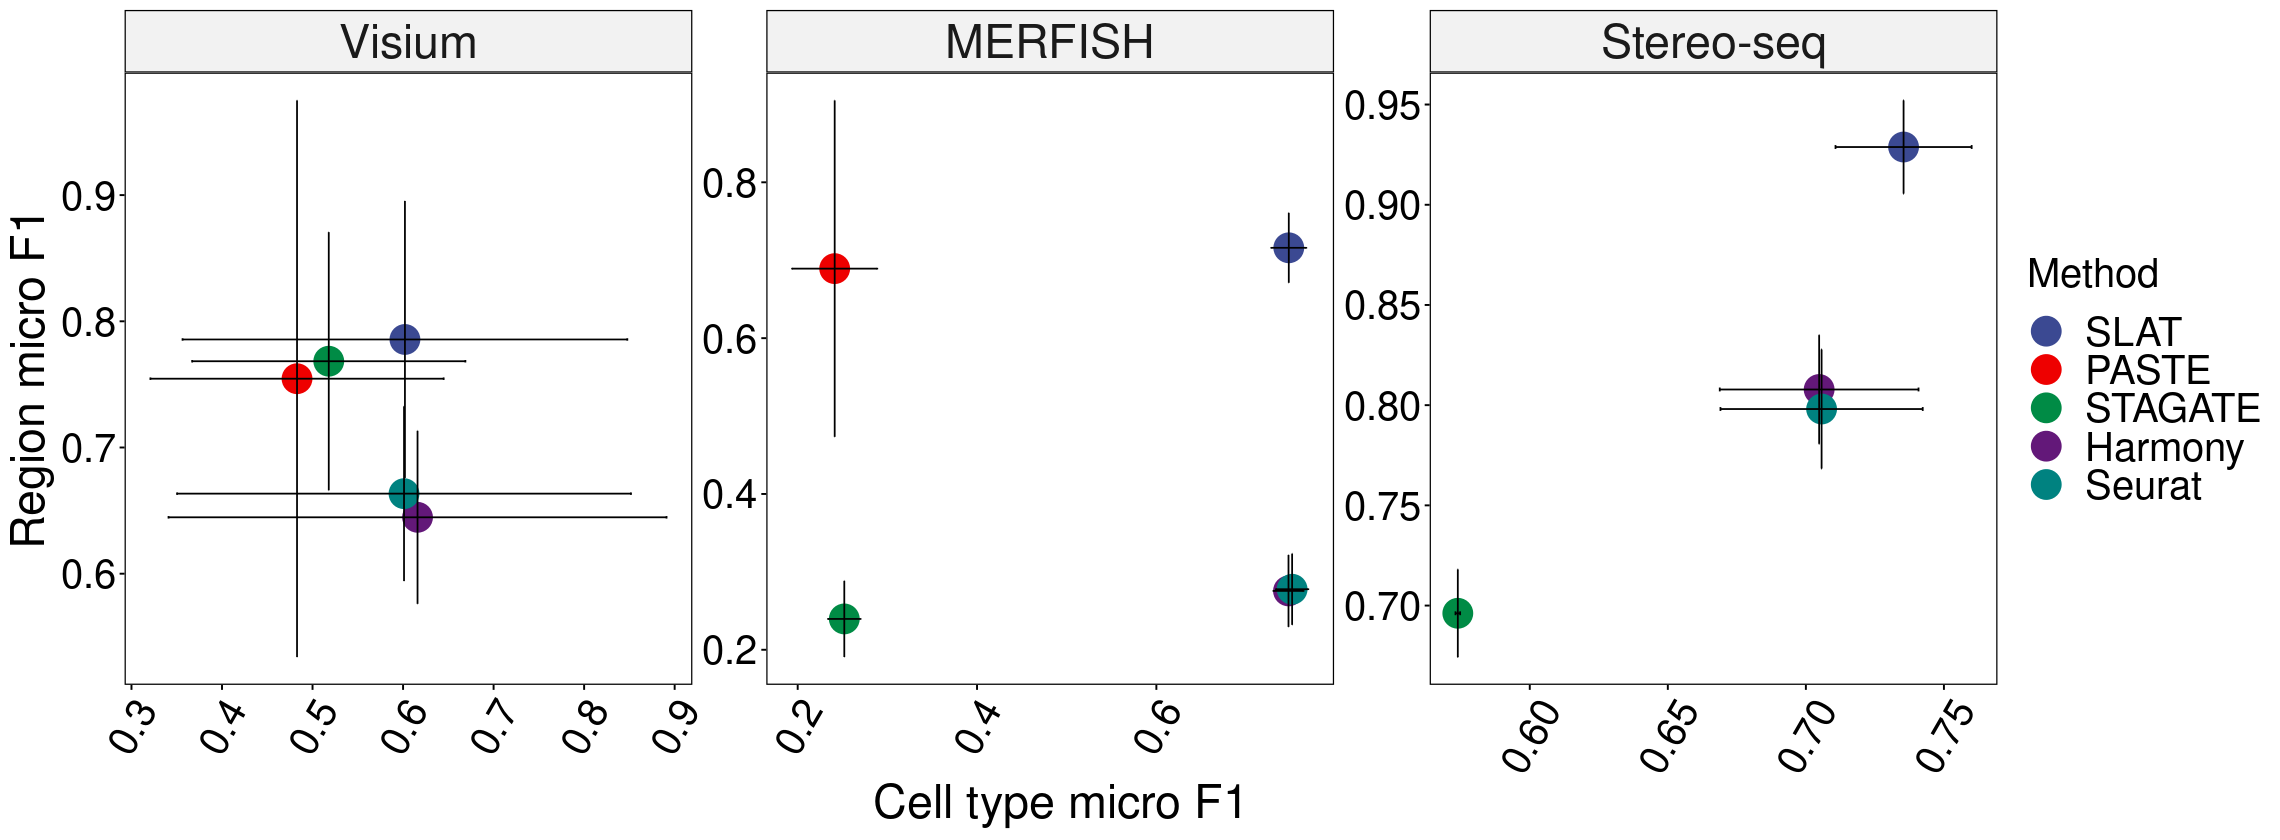

In [55]:
options(repr.plot.width=19, repr.plot.height=7)
# calculate mean and standard deviation for each method
stats <- data %>% group_by(method, group) %>%
    summarise(celltype_micro_f1_mean=mean(celltype_micro_f1), region_micro_f1_mean=mean(region_micro_f1),
            celltype_micro_f1_sd=sd(celltype_micro_f1), region_micro_f1_sd=sd(region_micro_f1))

# plot
ggscatter(stats, x="celltype_micro_f1_mean", y="region_micro_f1_mean", color='method', size=8,
        palette='aaas', xlab='Cell type micro F1', ylab='Region micro F1', lab.size=5, facet.by='group', label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28, font.x=28)+
geom_errorbarh(data = stats, aes(xmin = celltype_micro_f1_mean - celltype_micro_f1_sd,
                                 xmax = celltype_micro_f1_mean + celltype_micro_f1_sd),) +
                # width = 0.2 ,position = position_dodge(1)) + 
geom_errorbar(data = stats, aes(ymin = region_micro_f1_mean - region_micro_f1_sd,
                                 ymax = region_micro_f1_mean + region_micro_f1_sd),) +
                # width = 0.2, position = position_dodge(1)) + 
# stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.03, label = paste("", round(mean(x), 3))), geom="text", size=7.5) +
facet_wrap(~group, scales="free") +
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_errorbarh()`).”


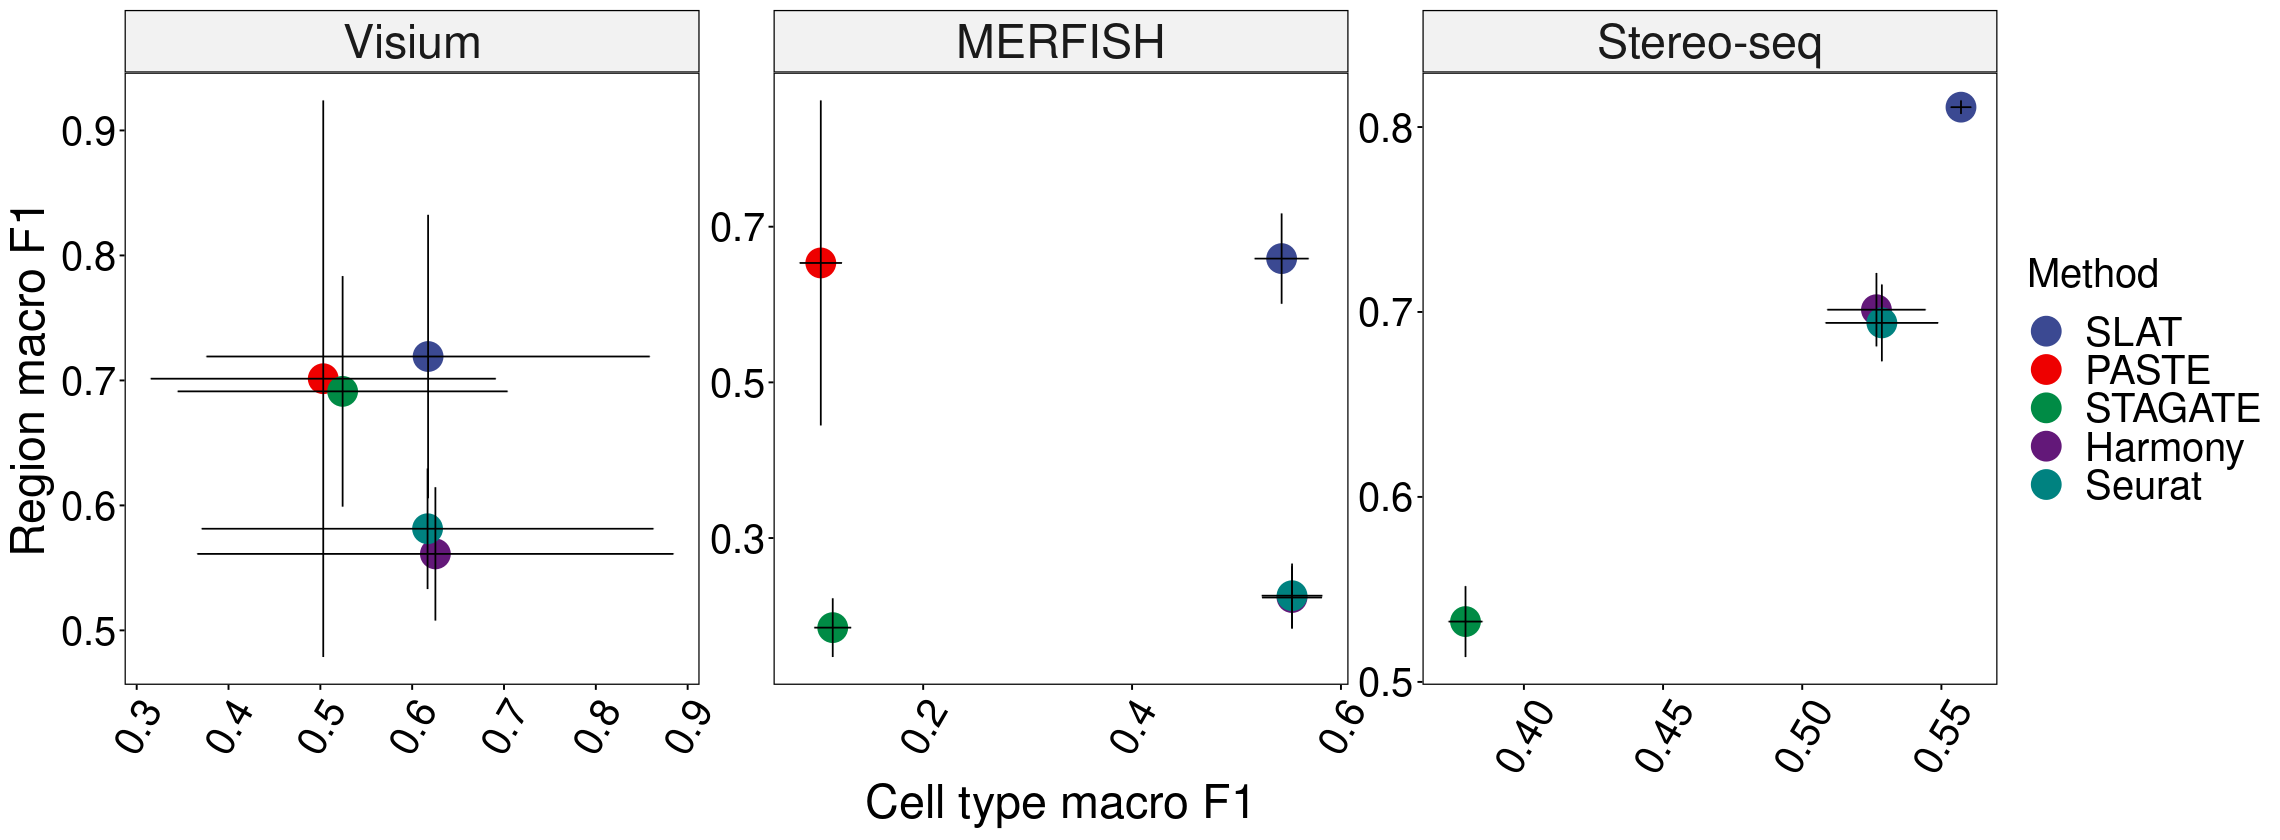

In [56]:
options(repr.plot.width=19, repr.plot.height=7)
# calculate mean and standard deviation for each method
stats <- data %>% group_by(method, group) %>%
    summarise(celltype_macro_f1_mean=mean(celltype_macro_f1), region_macro_f1_mean=mean(region_macro_f1),
            celltype_macro_f1_sd=sd(celltype_macro_f1), region_macro_f1_sd=sd(region_macro_f1))

# plot
ggscatter(stats, x="celltype_macro_f1_mean", y="region_macro_f1_mean", color='method', size=8,
        palette='aaas', xlab='Cell type macro F1' ,ylab='Region macro F1', lab.size=5, facet.by='group', label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28, font.x=28)+
geom_errorbarh(data = stats, aes(xmin = celltype_macro_f1_mean - celltype_macro_f1_sd,
                                 xmax = celltype_macro_f1_mean + celltype_macro_f1_sd),) +
                # width = 0.2 ,position = position_dodge(1)) + 
geom_errorbar(data = stats, aes(ymin = region_macro_f1_mean - region_macro_f1_sd,
                                 ymax = region_macro_f1_mean + region_macro_f1_sd),) +
                # width = 0.2, position = position_dodge(1)) + 
# stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.03, label = paste("", round(mean(x), 3))), geom="text", size=7.5) +
facet_wrap(~group, scales="free") +
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))

Warning message in base::min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"
Warning message in base::max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
"NaNs produced"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing missing values (`position_stack()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


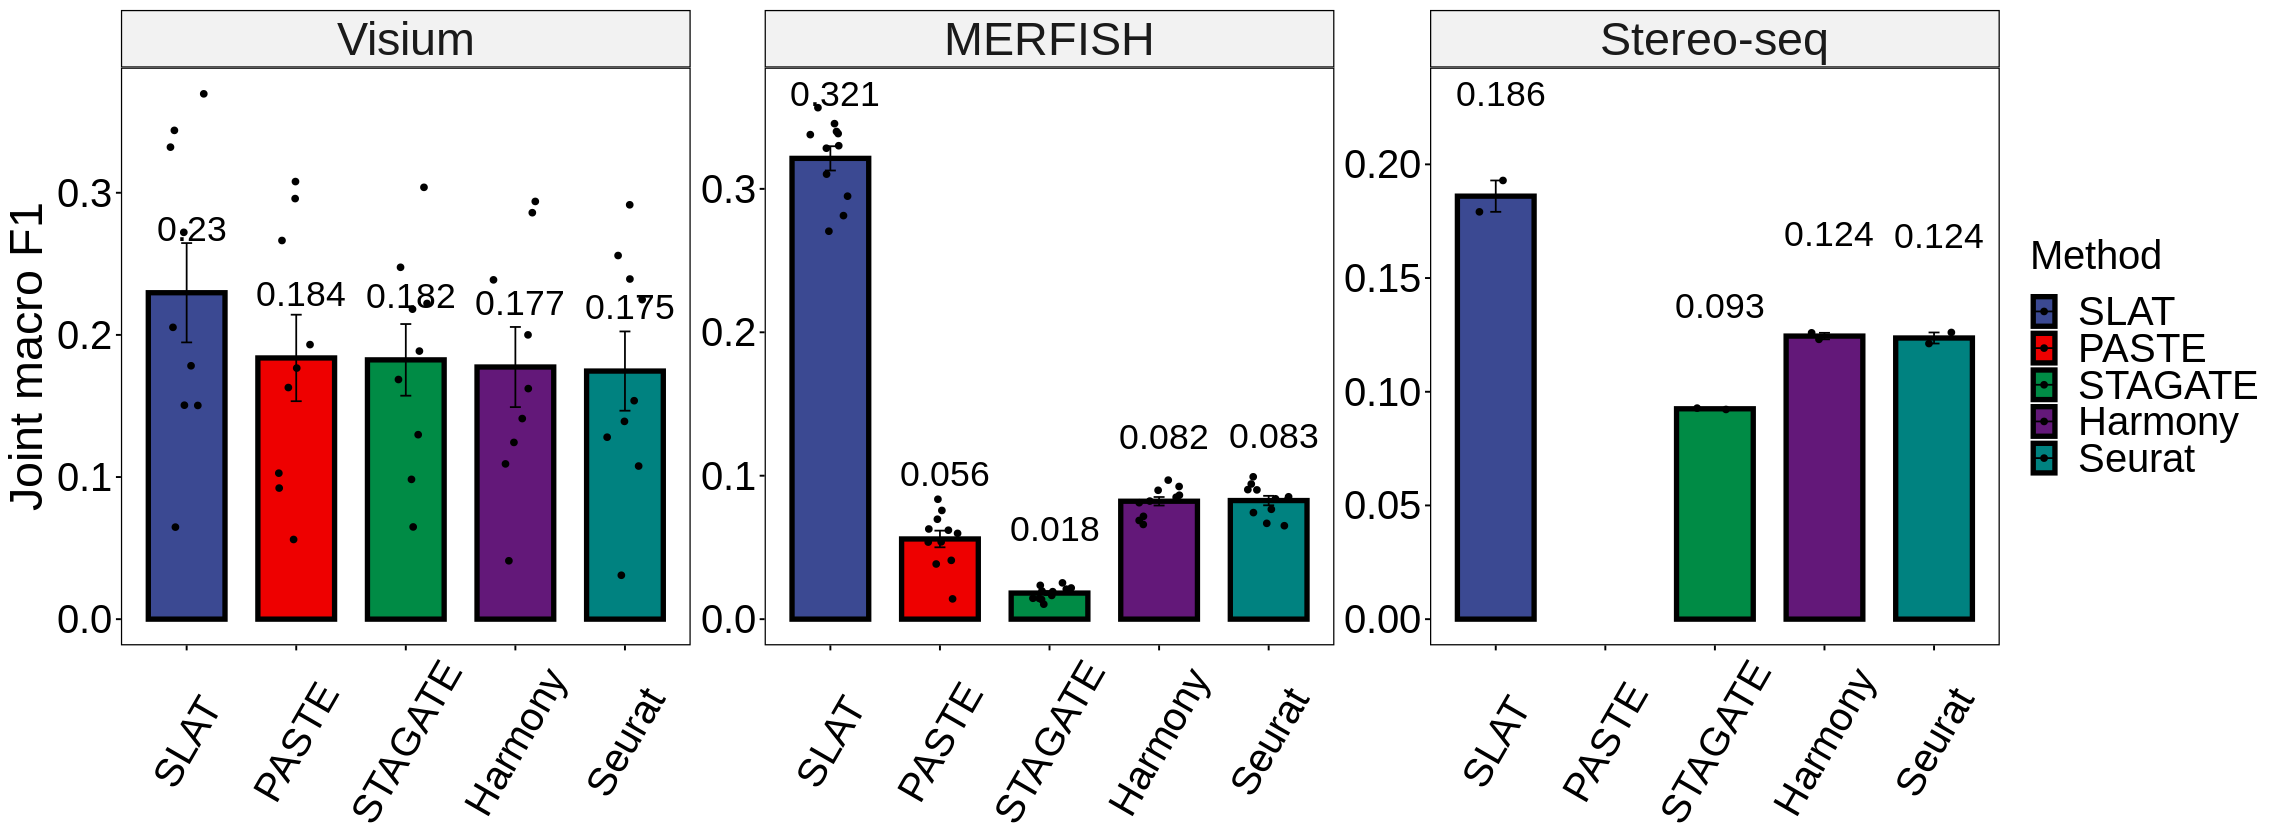

In [11]:
options(repr.plot.width=19, repr.plot.height=7)
ggbarplot(data, x="method", y="total_macro_f1", fill='method', color='method', add=c("mean_se", "jitter"),
        palette='aaas', xlab=F ,ylab='Joint macro F1', size=1.5, lab.size=5, facet.by='group', label=F, label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.045, label = paste("", round(mean(x), 3))), geom="text", size=7.5) +
facet_wrap(~group, scales="free") +
scale_color_manual(values = c(SLAT = "black", PASTE = "black", STAGATE = "black", Harmony = "black", Seurat = "black")) + 
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))

Warning message in base::min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"
Warning message in base::max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
"NaNs produced"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing missing values (`position_stack()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


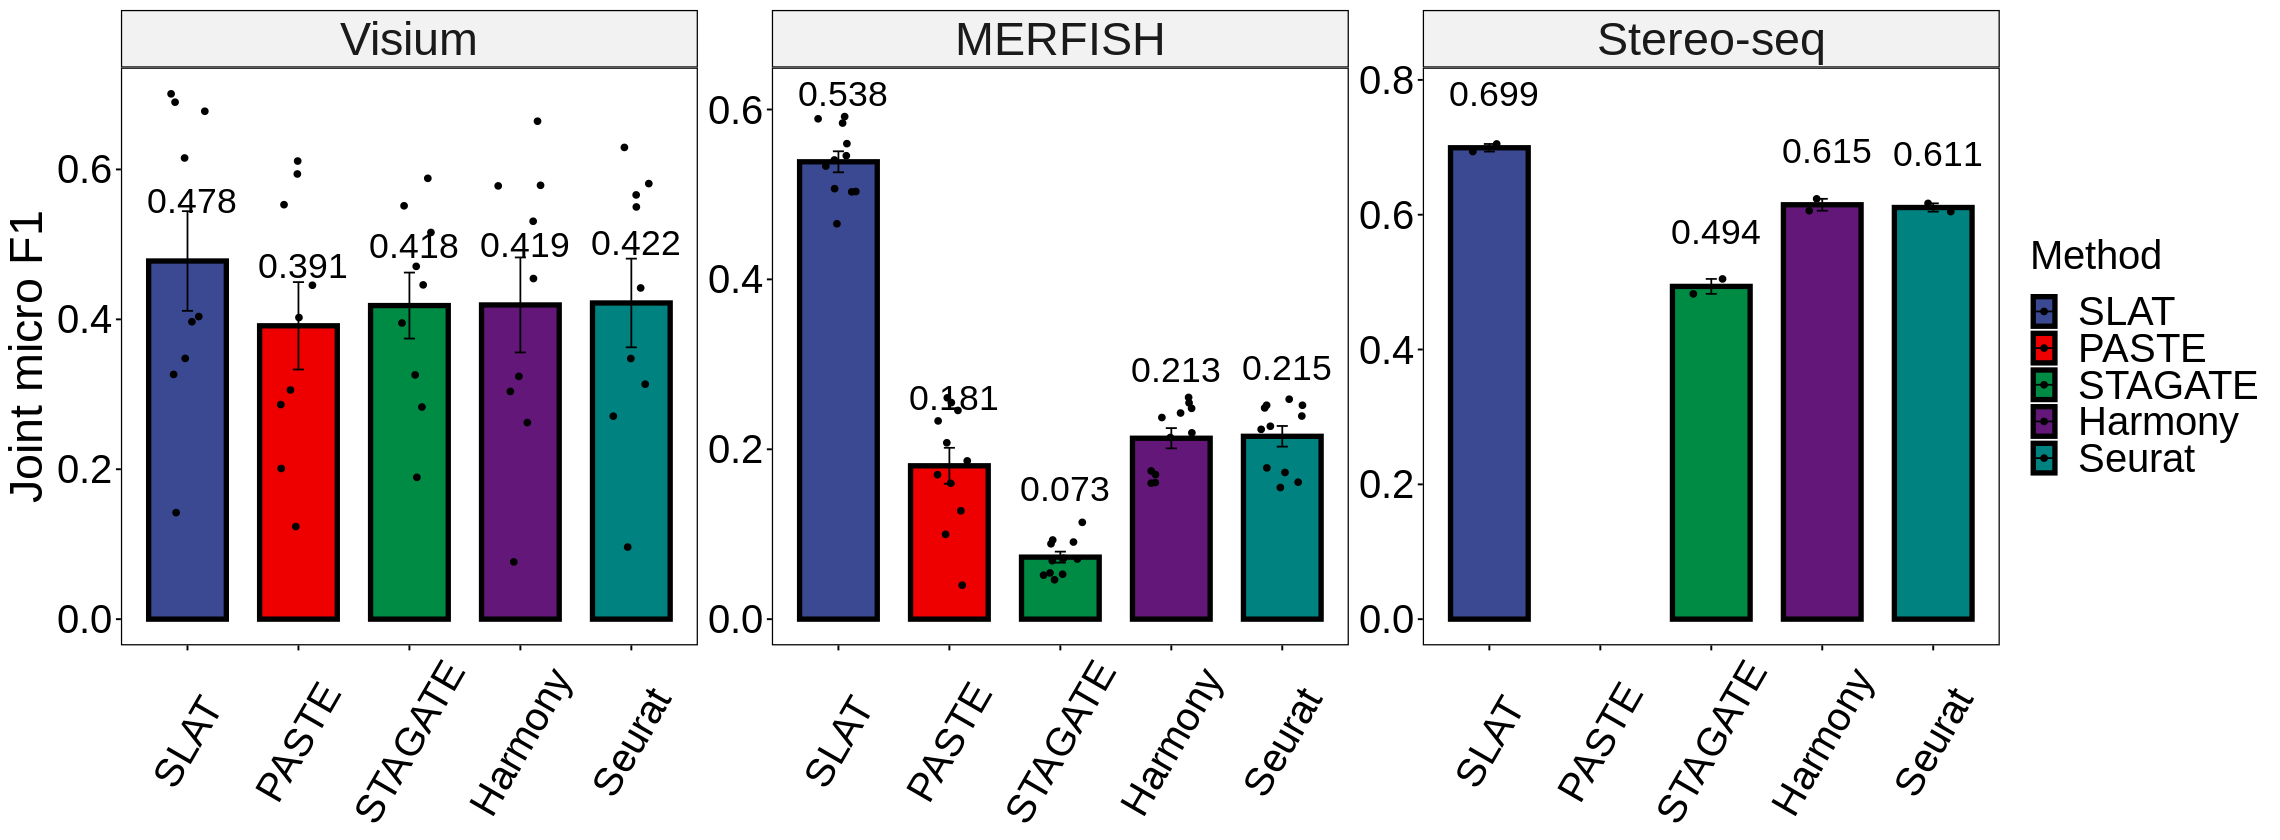

In [12]:
ggbarplot(data, x="method", y="total_micro_f1", fill='method', color='method', add=c("mean_se", "jitter"),
        palette='aaas', xlab=F ,ylab='Joint micro F1', size=1.5, lab.size=5, facet.by='group', label=F, label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.08, label = paste("", round(mean(x), 3))), geom="text", size=7.5) +
scale_color_manual(values = c(SLAT = "black", PASTE = "black", STAGATE = "black", Harmony = "black", Seurat = "black")) + 

facet_wrap(~group, scales="free") +
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))

## Joint accuracy

Warning message in base::min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"
Warning message in base::max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
"NaNs produced"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! 'x' and 'y' must have the same length"
Warning message:
"Removed 1 rows containing missing values (`position_stack()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


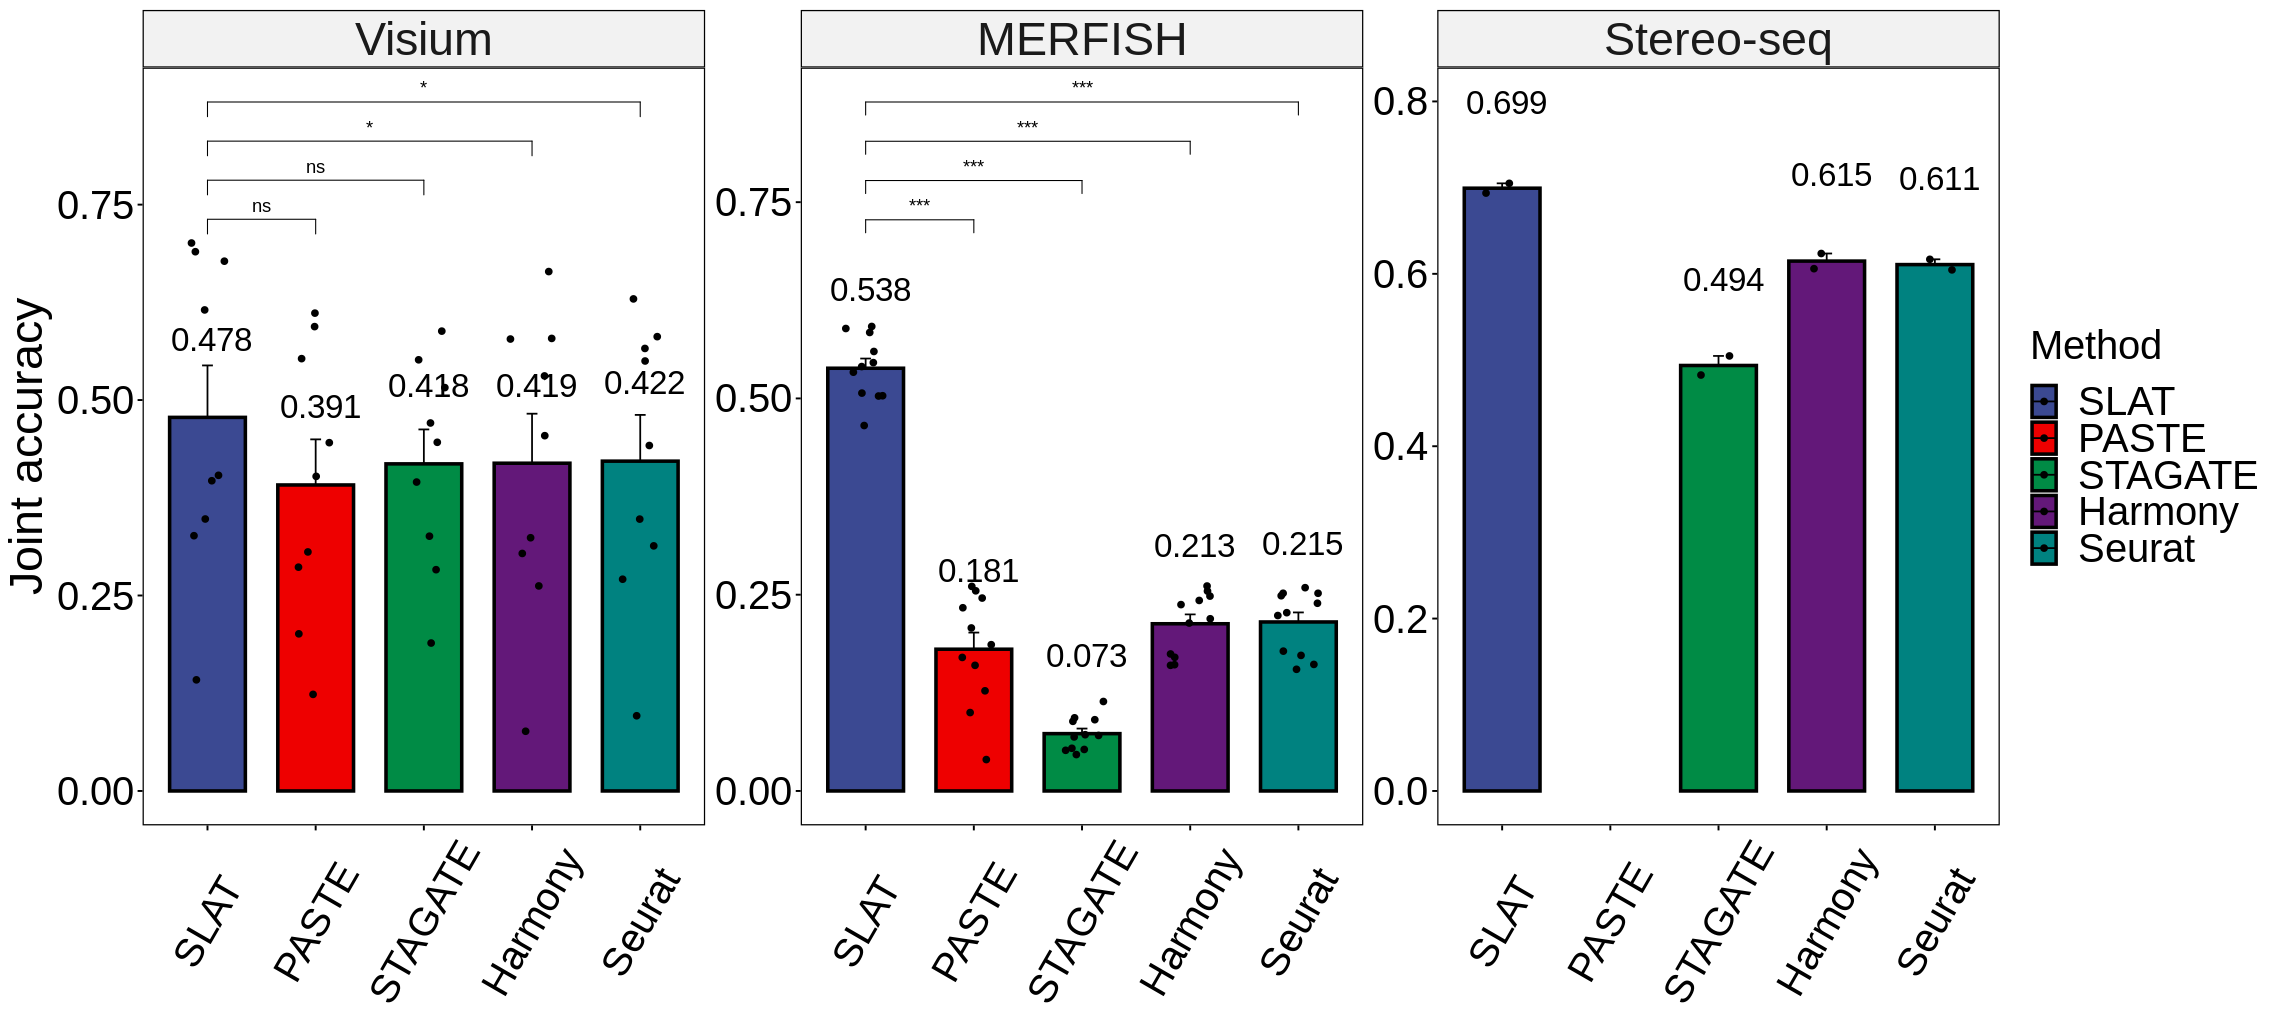

In [9]:
options(repr.plot.width=19, repr.plot.height=8.5)
ggbarplot(data, x="method", y="global_score", fill='method', color='method', add=c("mean_se", "jitter"), error.plot="upper_errorbar",
        palette='aaas', xlab=F ,ylab='Joint accuracy', size=1, lab.size=5, facet.by='group', label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x) + 0.1, label = paste("", round(mean(x), 3))), geom="text", size=7) +
facet_wrap(~group, scales="free") + 
scale_color_manual(values = c(SLAT = "black", PASTE = "black", STAGATE = "black", Harmony = "black", Seurat = "black")) + 
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28)) +
stat_compare_means(comparisons = list(c('SLAT','PASTE'),c('SLAT','STAGATE'),c('SLAT','Harmony'),c('SLAT','Seurat')),
                method = "wilcox.test", pair=T, label = "p.signif", label.y = c(0.7, 0.75, 0.80, 0.85))

Warning message in base::min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"
Warning message in base::max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
"NaNs produced"
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! 'x' and 'y' must have the same length"
Warning message:
"Removed 1 rows containing missing values (`position_stack()`)."


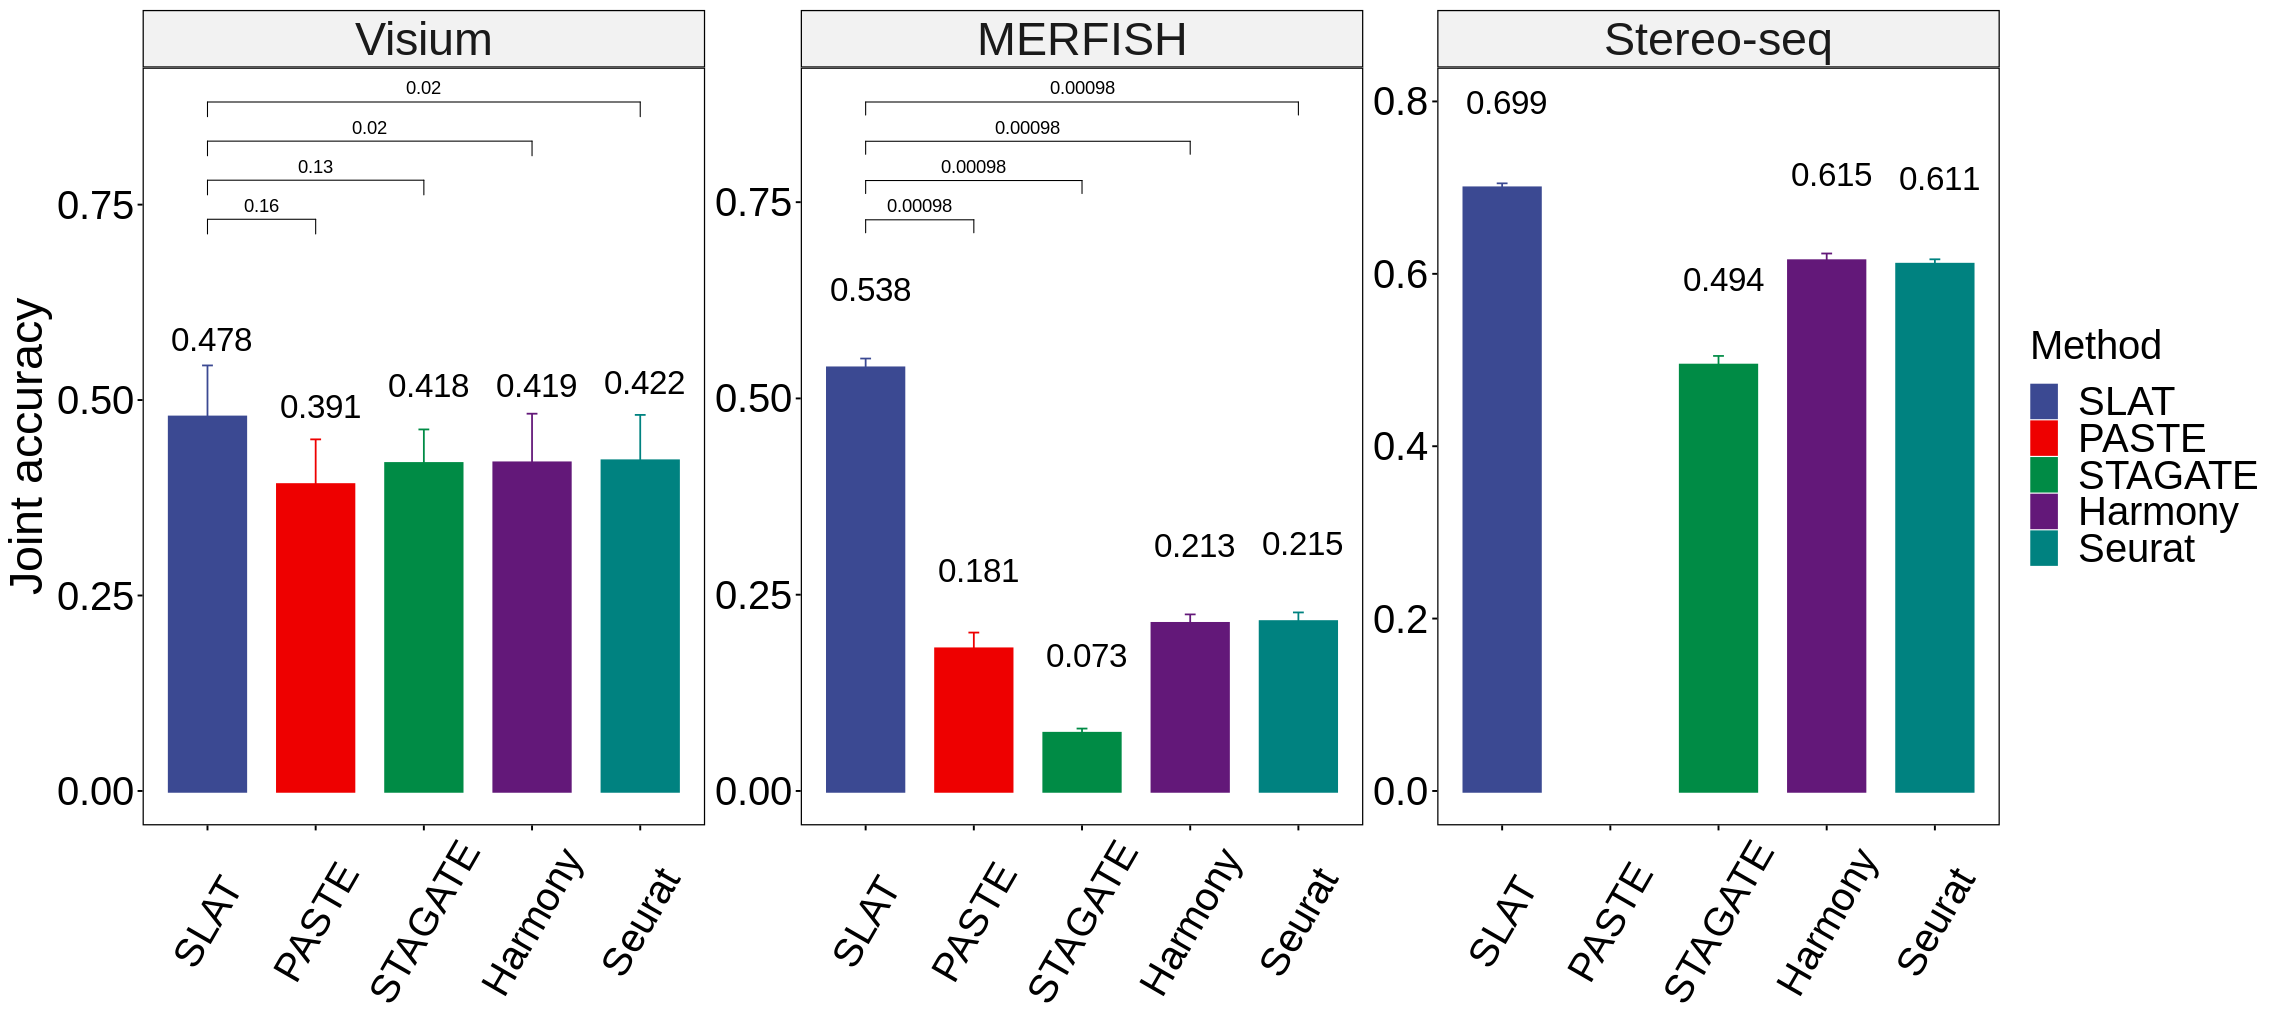

In [4]:
options(repr.plot.width=19, repr.plot.height=8.5)
ggbarplot(data, x="method", y="global_score", fill='method', color='method', add="mean_se", error.plot="upper_errorbar",
        palette='aaas', xlab=F ,ylab='Joint accuracy', size=1, lab.size=5, facet.by='group', label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x) + 0.1, label = paste("", round(mean(x), 3))), geom="text", size=7) +
facet_wrap(~group, scales="free") +
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28)) +
stat_compare_means(comparisons = list(c('SLAT','PASTE'),c('SLAT','STAGATE'),c('SLAT','Harmony'),c('SLAT','Seurat')),
                method = "wilcox.test", pair=T, label.y = c(0.7, 0.75, 0.80, 0.85))

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_errorbarh()`).”


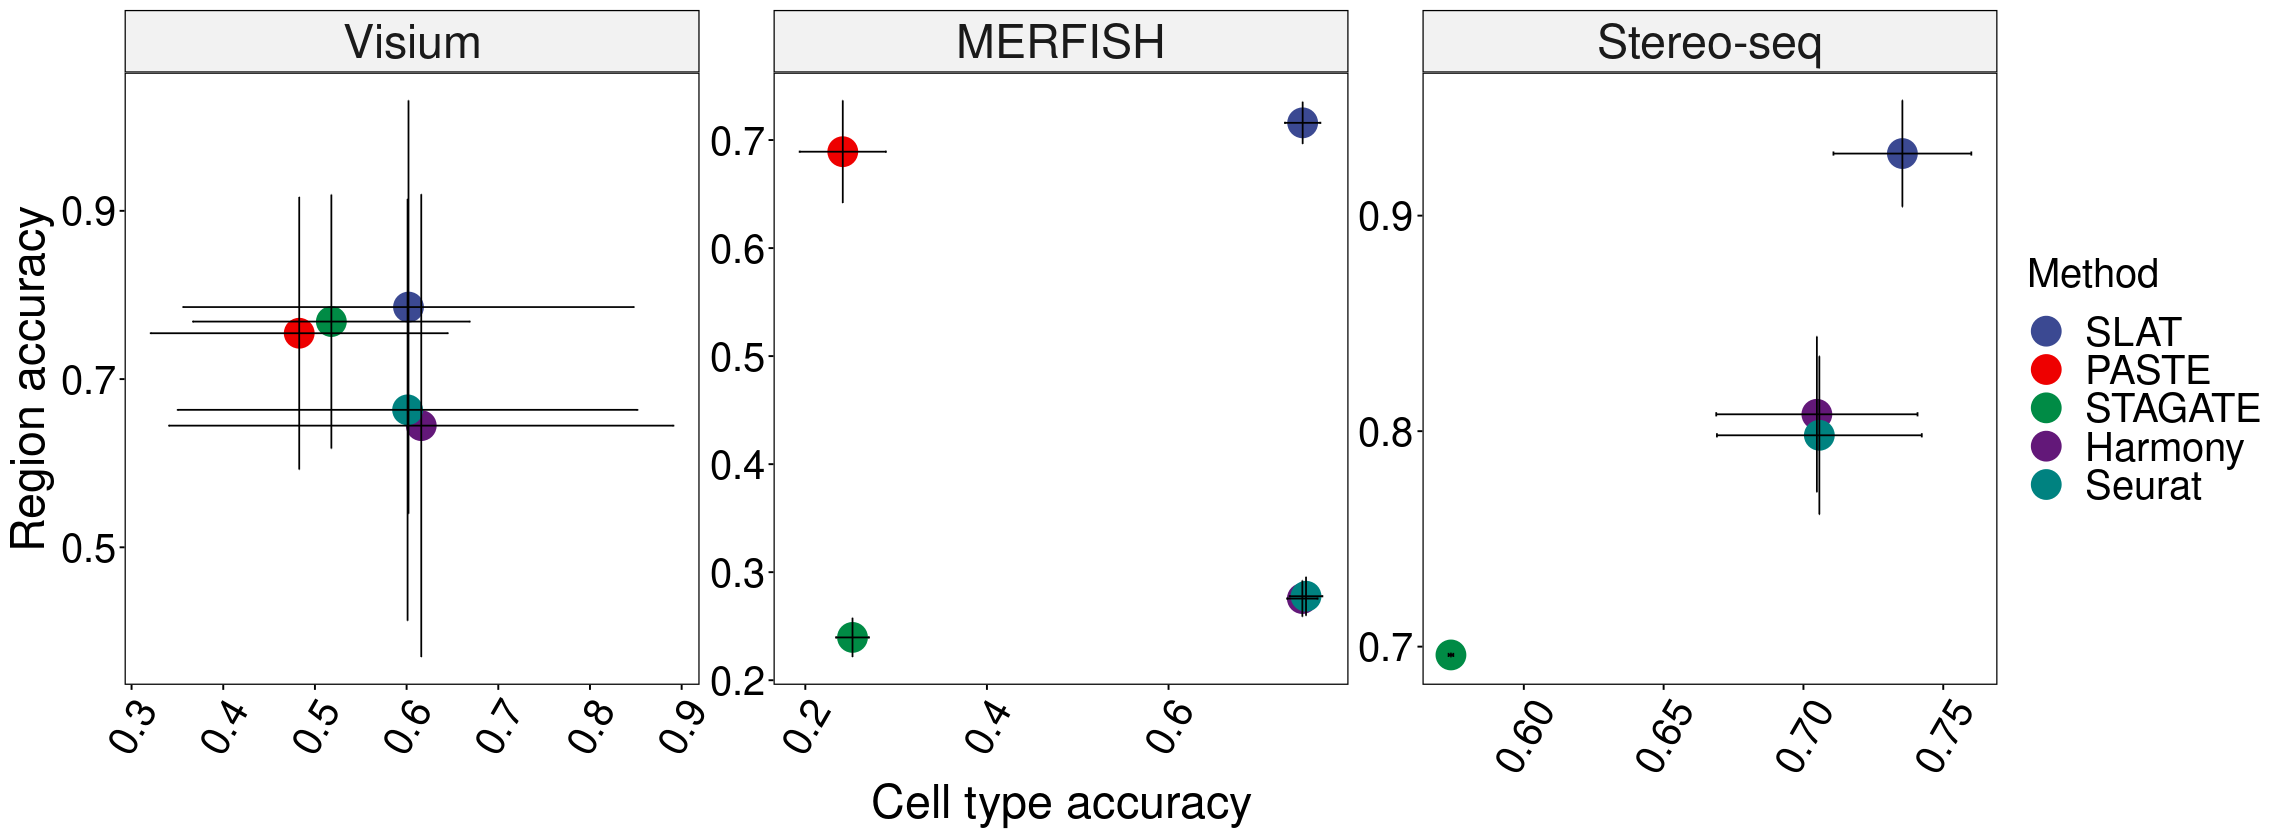

In [59]:
options(repr.plot.width=19, repr.plot.height=7)
# calculate mean and standard deviation for each method
stats <- data %>% group_by(method, group) %>%
    summarise(celltype_score_mean=mean(celltype_score), region_score_mean=mean(region_score),
            celltype_score_sd=sd(celltype_score), region_score_sd=sd(region_score))

# plot
ggscatter(stats, x="celltype_score_mean", y="region_score_mean", color='method', size=8,
        palette='aaas', xlab='Cell type accuracy' ,ylab='Region accuracy', lab.size=5, facet.by='group', label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28, font.x=28)+
# X axis error bar
geom_errorbarh(data = stats, aes(xmin = celltype_score_mean - celltype_score_sd,
                                 xmax = celltype_score_mean + celltype_score_sd),) +
                # width = 0.2 ,position = position_dodge(1)) + 
# Y axis error bar
geom_errorbar(data = stats, aes(ymin = region_score_mean - celltype_score_sd,
                                 ymax = region_score_mean + celltype_score_sd),) +
                # width = 0.2, position = position_dodge(1)) + 
# stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.03, label = paste("", round(mean(x), 3))), geom="text", size=7.5) +
facet_wrap(~group, scales="free") +
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))